In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=500

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Food_Classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1098 files belonging to 8 classes.


In [4]:
class_names = dataset.class_names
class_names

['red_velvet_cake',
 'samosa',
 'seaweed_salad',
 'spring_rolls',
 'strawberry_shortcake',
 'tacos',
 'tiramisu',
 'waffles']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 5 3 0 0 1 3 1 6 0 3 0 1 4 7 7 7 1 1 2 1 2 0 4 2 0 3 1 1 2 5]


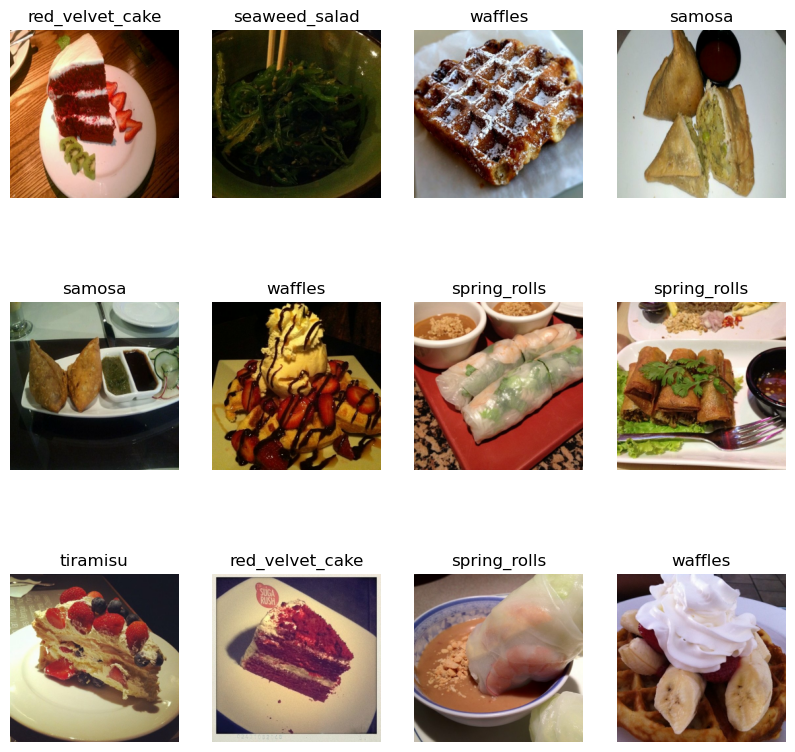

In [6]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

35

In [8]:
train_size = 0.8
len(dataset)*train_size

28.0

In [9]:
train_ds = dataset.take(28)
len(train_ds)

28

In [10]:
test_ds = dataset.skip(28)
len(test_ds)

7

In [11]:
val_size=0.1
len(dataset)*val_size

3.5

In [12]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [13]:
test_ds = test_ds.skip(3)
len(test_ds)

4

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

28

In [17]:
len(val_ds)

3

In [18]:
len(test_ds)

4

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=500,
)

Epoch 1/500
28/28 [==============================] - 42s 1s/step - loss: 2.0454 - accuracy: 0.1556 - val_loss: 1.8196 - val_accuracy: 0.2708
Epoch 2/500
28/28 [==============================] - 38s 1s/step - loss: 1.8552 - accuracy: 0.2414 - val_loss: 1.7209 - val_accuracy: 0.3125
Epoch 3/500
28/28 [==============================] - 35s 1s/step - loss: 1.8543 - accuracy: 0.2334 - val_loss: 1.7725 - val_accuracy: 0.2917
Epoch 4/500
28/28 [==============================] - 35s 1s/step - loss: 1.7962 - accuracy: 0.2654 - val_loss: 1.7400 - val_accuracy: 0.2604
Epoch 5/500
28/28 [==============================] - 41s 1s/step - loss: 1.7671 - accuracy: 0.3021 - val_loss: 1.6983 - val_accuracy: 0.3229
Epoch 6/500
28/28 [==============================] - 35s 1s/step - loss: 1.7642 - accuracy: 0.2918 - val_loss: 1.7216 - val_accuracy: 0.3646
Epoch 7/500
28/28 [==============================] - 34s 1s/step - loss: 1.6965 - accuracy: 0.2975 - val_loss: 1.5358 - val_accuracy: 0.4479
Epoch 8/500
2

Epoch 59/500
28/28 [==============================] - 44s 2s/step - loss: 0.8959 - accuracy: 0.6430 - val_loss: 0.9551 - val_accuracy: 0.6562
Epoch 60/500
28/28 [==============================] - 44s 2s/step - loss: 0.8633 - accuracy: 0.6842 - val_loss: 0.7958 - val_accuracy: 0.7083
Epoch 61/500
28/28 [==============================] - 44s 2s/step - loss: 0.8848 - accuracy: 0.6499 - val_loss: 0.7450 - val_accuracy: 0.7188
Epoch 62/500
28/28 [==============================] - 45s 2s/step - loss: 0.8218 - accuracy: 0.6865 - val_loss: 0.8020 - val_accuracy: 0.7396
Epoch 63/500
28/28 [==============================] - 44s 2s/step - loss: 0.8436 - accuracy: 0.6808 - val_loss: 0.7214 - val_accuracy: 0.7708
Epoch 64/500
28/28 [==============================] - 43s 2s/step - loss: 0.8867 - accuracy: 0.6716 - val_loss: 0.8235 - val_accuracy: 0.7083
Epoch 65/500
28/28 [==============================] - 44s 2s/step - loss: 0.8008 - accuracy: 0.6934 - val_loss: 0.8991 - val_accuracy: 0.6354
Epoch 

28/28 [==============================] - 44s 2s/step - loss: 0.3690 - accuracy: 0.8455 - val_loss: 0.5893 - val_accuracy: 0.8542
Epoch 117/500
28/28 [==============================] - 44s 2s/step - loss: 0.3391 - accuracy: 0.8753 - val_loss: 0.6244 - val_accuracy: 0.8542
Epoch 118/500
28/28 [==============================] - 43s 2s/step - loss: 0.3804 - accuracy: 0.8478 - val_loss: 0.5661 - val_accuracy: 0.8750
Epoch 119/500
28/28 [==============================] - 43s 2s/step - loss: 0.4421 - accuracy: 0.8490 - val_loss: 0.6287 - val_accuracy: 0.8021
Epoch 120/500
28/28 [==============================] - 43s 2s/step - loss: 0.4711 - accuracy: 0.8215 - val_loss: 0.6102 - val_accuracy: 0.8229
Epoch 121/500
28/28 [==============================] - 44s 2s/step - loss: 0.3583 - accuracy: 0.8696 - val_loss: 0.5733 - val_accuracy: 0.8438
Epoch 122/500
28/28 [==============================] - 43s 2s/step - loss: 0.3108 - accuracy: 0.8833 - val_loss: 0.7143 - val_accuracy: 0.8438
Epoch 123/500

28/28 [==============================] - 44s 2s/step - loss: 0.1304 - accuracy: 0.9451 - val_loss: 0.5551 - val_accuracy: 0.9271
Epoch 174/500
28/28 [==============================] - 43s 2s/step - loss: 0.1364 - accuracy: 0.9497 - val_loss: 0.8378 - val_accuracy: 0.8125
Epoch 175/500
28/28 [==============================] - 44s 2s/step - loss: 0.1808 - accuracy: 0.9314 - val_loss: 0.7252 - val_accuracy: 0.9062
Epoch 176/500
28/28 [==============================] - 43s 2s/step - loss: 0.1645 - accuracy: 0.9382 - val_loss: 0.5800 - val_accuracy: 0.8750
Epoch 177/500
28/28 [==============================] - 43s 2s/step - loss: 0.1982 - accuracy: 0.9279 - val_loss: 0.7311 - val_accuracy: 0.8854
Epoch 178/500
28/28 [==============================] - 44s 2s/step - loss: 0.2466 - accuracy: 0.9153 - val_loss: 0.7171 - val_accuracy: 0.8646
Epoch 179/500
28/28 [==============================] - 44s 2s/step - loss: 0.2978 - accuracy: 0.8982 - val_loss: 0.8514 - val_accuracy: 0.8125
Epoch 180/500

28/28 [==============================] - 43s 2s/step - loss: 0.0961 - accuracy: 0.9748 - val_loss: 0.6610 - val_accuracy: 0.9167
Epoch 231/500
28/28 [==============================] - 43s 2s/step - loss: 0.1906 - accuracy: 0.9451 - val_loss: 0.6359 - val_accuracy: 0.8854
Epoch 232/500
28/28 [==============================] - 43s 2s/step - loss: 0.1502 - accuracy: 0.9474 - val_loss: 0.6300 - val_accuracy: 0.8958
Epoch 233/500
28/28 [==============================] - 48s 2s/step - loss: 0.2116 - accuracy: 0.9291 - val_loss: 0.9472 - val_accuracy: 0.8646
Epoch 234/500
28/28 [==============================] - 43s 2s/step - loss: 0.2056 - accuracy: 0.9302 - val_loss: 0.8344 - val_accuracy: 0.8646
Epoch 235/500
28/28 [==============================] - 43s 2s/step - loss: 0.2666 - accuracy: 0.9222 - val_loss: 1.0566 - val_accuracy: 0.8229
Epoch 236/500
28/28 [==============================] - 43s 2s/step - loss: 0.2445 - accuracy: 0.9199 - val_loss: 0.6014 - val_accuracy: 0.8750
Epoch 237/500

28/28 [==============================] - 43s 2s/step - loss: 0.1489 - accuracy: 0.9497 - val_loss: 0.8118 - val_accuracy: 0.8854
Epoch 288/500
28/28 [==============================] - 44s 2s/step - loss: 0.1100 - accuracy: 0.9577 - val_loss: 0.7599 - val_accuracy: 0.9167
Epoch 289/500
28/28 [==============================] - 43s 2s/step - loss: 0.0649 - accuracy: 0.9771 - val_loss: 0.7375 - val_accuracy: 0.9167
Epoch 290/500
28/28 [==============================] - 43s 2s/step - loss: 0.0901 - accuracy: 0.9634 - val_loss: 0.9256 - val_accuracy: 0.8854
Epoch 291/500
28/28 [==============================] - 43s 2s/step - loss: 0.1056 - accuracy: 0.9691 - val_loss: 0.6383 - val_accuracy: 0.9375
Epoch 292/500
28/28 [==============================] - 43s 2s/step - loss: 0.1007 - accuracy: 0.9657 - val_loss: 0.8968 - val_accuracy: 0.8750
Epoch 293/500
28/28 [==============================] - 43s 2s/step - loss: 0.0680 - accuracy: 0.9805 - val_loss: 0.7312 - val_accuracy: 0.9062
Epoch 294/500

28/28 [==============================] - 43s 2s/step - loss: 0.2069 - accuracy: 0.9325 - val_loss: 0.7223 - val_accuracy: 0.8646
Epoch 345/500
28/28 [==============================] - 43s 2s/step - loss: 0.0985 - accuracy: 0.9611 - val_loss: 0.9934 - val_accuracy: 0.8750
Epoch 346/500
28/28 [==============================] - 44s 2s/step - loss: 0.1167 - accuracy: 0.9565 - val_loss: 0.5433 - val_accuracy: 0.8854
Epoch 347/500
28/28 [==============================] - 43s 2s/step - loss: 0.0466 - accuracy: 0.9828 - val_loss: 0.6114 - val_accuracy: 0.9271
Epoch 348/500
28/28 [==============================] - 43s 2s/step - loss: 0.0301 - accuracy: 0.9897 - val_loss: 0.6446 - val_accuracy: 0.9375
Epoch 349/500
28/28 [==============================] - 44s 2s/step - loss: 0.0301 - accuracy: 0.9920 - val_loss: 0.7317 - val_accuracy: 0.9375
Epoch 350/500
28/28 [==============================] - 44s 2s/step - loss: 0.0314 - accuracy: 0.9863 - val_loss: 0.6223 - val_accuracy: 0.9375
Epoch 351/500

28/28 [==============================] - 43s 2s/step - loss: 0.0402 - accuracy: 0.9851 - val_loss: 0.9549 - val_accuracy: 0.9271
Epoch 402/500
28/28 [==============================] - 43s 2s/step - loss: 0.0615 - accuracy: 0.9771 - val_loss: 0.9608 - val_accuracy: 0.9271
Epoch 403/500
28/28 [==============================] - 43s 2s/step - loss: 0.0744 - accuracy: 0.9737 - val_loss: 0.8071 - val_accuracy: 0.9062
Epoch 404/500
28/28 [==============================] - 45s 2s/step - loss: 0.0995 - accuracy: 0.9680 - val_loss: 1.0159 - val_accuracy: 0.9375
Epoch 405/500
28/28 [==============================] - 44s 2s/step - loss: 0.0715 - accuracy: 0.9748 - val_loss: 0.9467 - val_accuracy: 0.8854
Epoch 406/500
28/28 [==============================] - 43s 2s/step - loss: 0.0668 - accuracy: 0.9771 - val_loss: 0.8235 - val_accuracy: 0.9375
Epoch 407/500
28/28 [==============================] - 43s 2s/step - loss: 0.1263 - accuracy: 0.9691 - val_loss: 0.8789 - val_accuracy: 0.8958
Epoch 408/500

28/28 [==============================] - 43s 2s/step - loss: 0.0592 - accuracy: 0.9805 - val_loss: 0.8721 - val_accuracy: 0.9167
Epoch 459/500
28/28 [==============================] - 44s 2s/step - loss: 0.0347 - accuracy: 0.9886 - val_loss: 0.7451 - val_accuracy: 0.9167
Epoch 460/500
28/28 [==============================] - 43s 2s/step - loss: 0.0128 - accuracy: 0.9989 - val_loss: 0.8558 - val_accuracy: 0.9375
Epoch 461/500
28/28 [==============================] - 46s 2s/step - loss: 0.0326 - accuracy: 0.9920 - val_loss: 0.9007 - val_accuracy: 0.9167
Epoch 462/500
28/28 [==============================] - 43s 2s/step - loss: 0.0174 - accuracy: 0.9920 - val_loss: 0.7394 - val_accuracy: 0.9271
Epoch 463/500
28/28 [==============================] - 43s 2s/step - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.8073 - val_accuracy: 0.9479
Epoch 464/500
28/28 [==============================] - 43s 2s/step - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.8152 - val_accuracy: 0.9375
Epoch 465/500

In [27]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 4s 274ms/step - loss: 0.8307 - accuracy: 0.8984


In [28]:
scores

[0.830720841884613, 0.8984375]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 500, 'steps': 28}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

500

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.0454368591308594,
 1.8552472591400146,
 1.854303240776062,
 1.79624342918396,
 1.7670506238937378]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

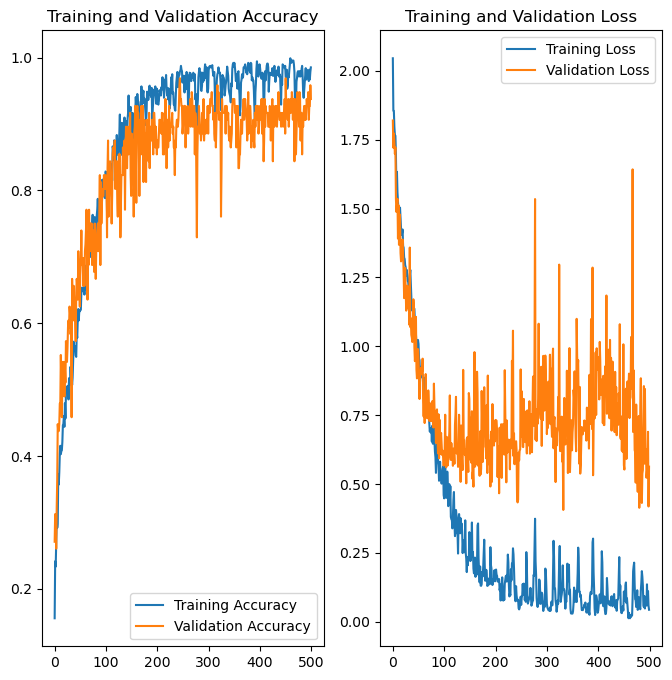

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: seaweed_salad
1/1 [==============================] - 0s 311ms/step
predicted label: seaweed_salad


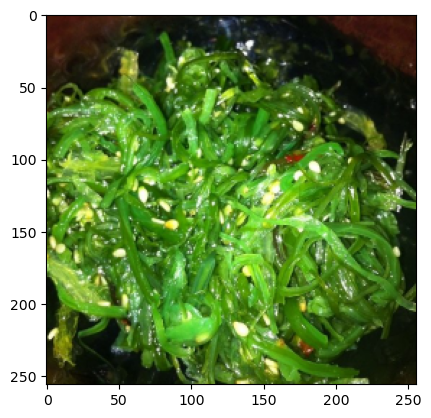

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


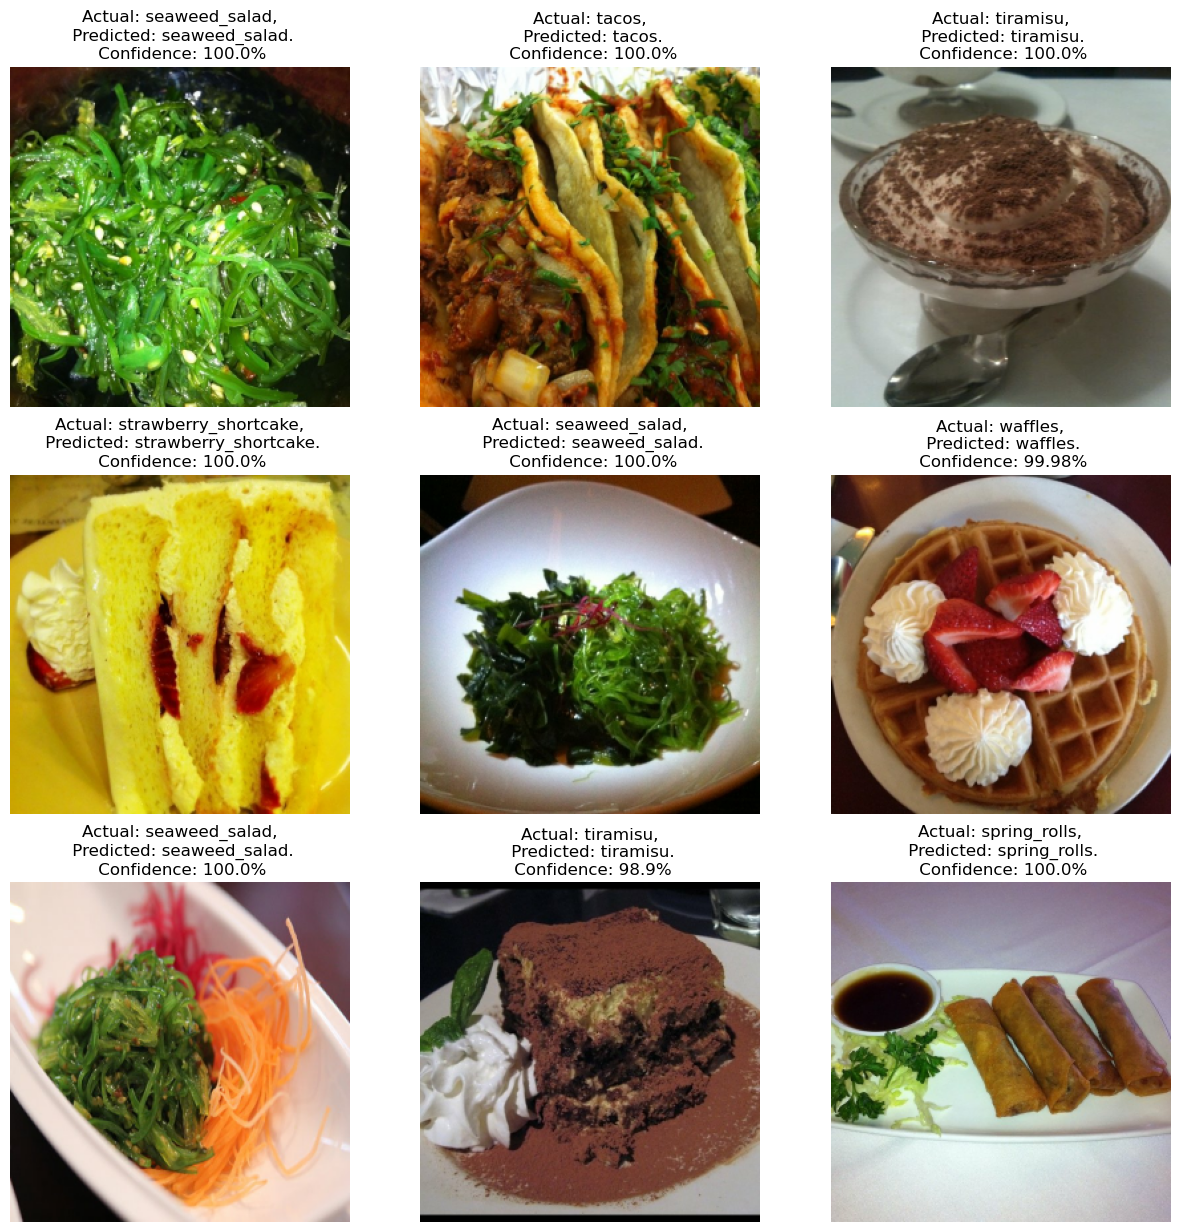

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
